# Pokemon Type Analysis and Visualization

In this notebook, I used the NetworkX library to conduct graph data analysis and visualization relating to Pokemon types.

Pokemon and battle moves are associated with specific types (ex. Grass, Water, Fire, etc.). Depending on the type matchup, battle moves can be super effective/not very effective when used on certain Pokemon. For example, Water type moves are super effective against Fire type Pokemon, making them advantageous in battle. I wanted to use graphs to visualize the relationships between different Pokemon types and build a tool that players can use to identify which types their Pokemon are weak or resistant to.

In [531]:
import pandas as pd
import networkx as nx
import math
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [532]:
# importing data about Pokemon types

pk_type_chart = pd.read_csv("Pokemon Type Chart.csv")
pk_type_chart = pokemon_type_chart.rename(columns={"Unnamed: 0": "Type"})

In [530]:
pk_type_chart

,Type,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
0,Normal,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,1.0,1.0,0.5,1.0
1,Fire,1.0,0.5,0.5,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,0.5,1.0,2.0,1.0
2,Water,1.0,2.0,0.5,1.0,0.5,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,1.0,1.0
3,Electric,1.0,1.0,2.0,0.5,0.5,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0
4,Grass,1.0,0.5,2.0,1.0,0.5,1.0,1.0,0.5,2.0,0.5,1.0,0.5,2.0,1.0,0.5,1.0,0.5,1.0
5,Ice,1.0,0.5,0.5,1.0,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0
6,Fighting,2.0,1.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,0.5,0.5,0.5,2.0,0.0,1.0,2.0,2.0,0.5
7,Poison,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.5,0.5,1.0,1.0,1.0,0.5,0.5,1.0,1.0,0.0,2.0
8,Ground,1.0,2.0,1.0,2.0,0.5,1.0,1.0,2.0,1.0,0.0,1.0,0.5,2.0,1.0,1.0,1.0,2.0,1.0
9,Flying,1.0,1.0,1.0,0.5,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,1.0,1.0,0.5,1.0


This chart shows a matrix view of type effectiveness, with the following number representations:

- 2.0: super effective
- 1.0: neutral
- 0.5: not very effective
- 0.0: no effect

The chart shows relationships with the row types attacking the column types. For example, we can see that Flying is super effective against Fighting since there is a 2.0 value at their intersection. I converted this view into a dataframe format for the rest of my analysis.

In [353]:
type_list = list(pokemon_type_chart.columns)[1:]
pk_type_chart_melt = pd.melt(pk_type_chart, id_vars='Type', value_vars=type_list)
pk_type_chart_melt = pk_type_chart_melt.rename(columns={"Type": "Type 1", "variable": "Type 2", "value": "weight"})
pk_type_chart_no_neutral = pk_type_chart_melt[pk_type_chart_melt["weight"] != 1] # removing all neutral relationships to decrease clutter in graphs
pk_type_chart_no_neutral

,Type 1,Type 2,weight
6,Fighting,Normal,2.0
13,Ghost,Normal,0.0
19,Fire,Fire,0.5
20,Water,Fire,2.0
22,Grass,Fire,0.5
...,...,...,...
313,Poison,Fairy,2.0
317,Bug,Fairy,0.5
320,Dragon,Fairy,0.0
321,Dark,Fairy,0.5


In [354]:
pk_type_chart_effective = pk_type_chart_no_neutral[pk_type_chart_no_neutral["weight"] == 2] # super effective
pk_type_chart_not_effective = pk_type_chart_no_neutral[pk_type_chart_no_neutral["weight"] == 0.5] # not very effective
pk_type_chart_immunity = pk_type_chart_no_neutral[pk_type_chart_no_neutral["weight"] == 0] # immunity: not used in graph representations due to lower number of types/relationships

I tried experimenting with several graph layouts to see which one would effectively visualize the connections between different types (https://networkx.org/documentation/stable/reference/drawing.html). I settled on using two layouts for each of my graphs:

1. **Kamada-Kawai**: models the graph as a physical system of springs, where nodes are particles and edges and springs. Nodes are positioned such that the geometric distances between nodes minimizes the overall stress on the system.
2. **Spring**: creates a system where nodes are repellents and edges are strings that pull them together. Node positions are adjusted until a stable diagram is achieved, which means that **strongly connected nodes are clustered together.** Based off of the Fruchterman-Reingold force-directed algorithm.

I used the Kamada-Kawai layout to clearly show relationships without much node clustering, and the Spring layout to show which types are anomalies in each graph.

In [345]:
# FUNCTION: creates the Kamada Kawai and Spring representations of a NetworkX graph
# color coding represents the out degree of each node: nodes with a darker color have more connections pointing out of it

def create_graph_visual(Graph, graph_name):
    # dictionary of each type and its out degree
    graph_dict = dict(Graph.out_degree())
    graph_dict = dict(sorted(graph_dict.items(), key=lambda x:x[1], reverse=True))

    # creating color coding for each of the nodes according to their out degree
    # used the OrRd colormap -- darker reds correspond to a larger out degree
    norm = mcolors.Normalize(vmin=min(graph_dict.values()), vmax=max(graph_dict.values()))
    colormap = plt.cm.OrRd
    node_colors = [colormap(norm(graph_dict[node])) for node in Graph.nodes()]

    # representing the graph in Kamada-Kawai Layout
    fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 
    nx.draw_networkx(Graph, ax=axes[0], pos=nx.kamada_kawai_layout(Graph), with_labels=True, arrows=True, arrowstyle='-|>', node_size=700, font_size=9,
                    node_color=node_colors);
    axes[0].set_title(f"{graph_name} - Kamada Kawai Layout");

    # representing the graph in Spring Layout
    nx.draw_networkx(Graph, ax=axes[1], pos=nx.spring_layout(Graph), with_labels=True, arrows=True, arrowstyle='-|>', node_size=700, font_size=9,
                    node_color=node_colors);
    axes[1].set_title(f"{graph_name} - Spring Layout");

    # plotting the graphs
    plt.tight_layout()
    plt.show();

    graph_df = pd.DataFrame.from_dict({"Type": list(graph_dict.keys()), "Out Degree": list(graph_dict.values())})
    print(graph_df)

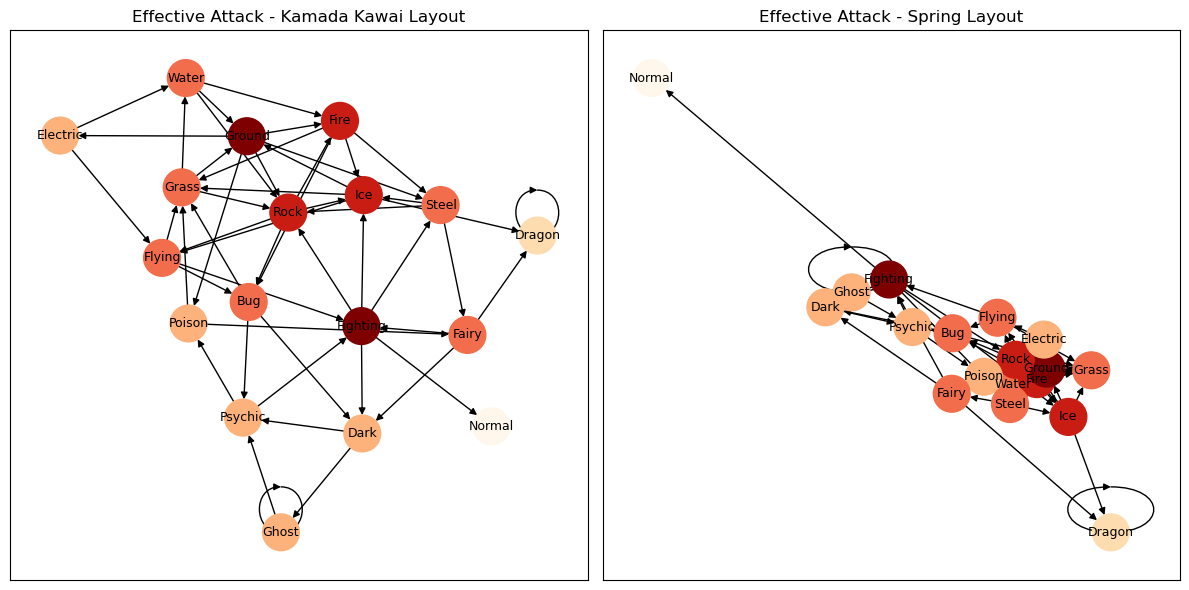

        Type  Out Degree
0   Fighting           5
1     Ground           5
2       Fire           4
3       Rock           4
4        Ice           4
5      Water           3
6      Grass           3
7     Flying           3
8        Bug           3
9      Steel           3
10     Fairy           3
11  Electric           2
12    Poison           2
13   Psychic           2
14     Ghost           2
15      Dark           2
16    Dragon           1
17    Normal           0


In [346]:
# Attacking Type ------> Defending Type
# Arrows indicate that the attacking type is super effective against the defending type (ex. Fighting is super effective against Normal)

Effective_Attack_Graph = nx.from_pandas_edgelist(pk_type_chart_effective, "Type 1", "Type 2", create_using=nx.DiGraph())
create_graph_visual(Effective_Attack_Graph, "Effective Attack")

**Conclusion**: Fighting and Ground are effective against the most number of types, while Normal is effective against zero other types. Dragon and Ghost each also have a strength against itself.

The spring layout representation show Normal and Dragon as being anomalies, located further away from the cluster of the rest of the types. This comes as a result of Normal and Dragon not being well-connected with the other types, since:

- Normal doesn't have strengths against any other types --> its out degree is zero.
- Dragon has only one strength against itself --> its out degree is one, but it does not point toward any other types.

Generating another spring layout of the Effective Attack Graph will yield a similar result, with Normal and Dragon being isolated from the rest.

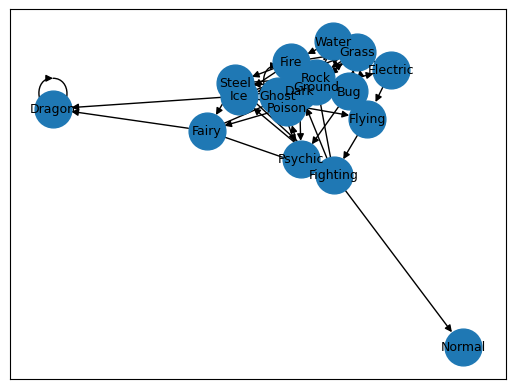

In [456]:
nx.draw_networkx(Effective_Attack_Graph, pos=nx.spring_layout(Effective_Attack_Graph), with_labels=True, arrows=True, arrowstyle='-|>', node_size=700, font_size=9);

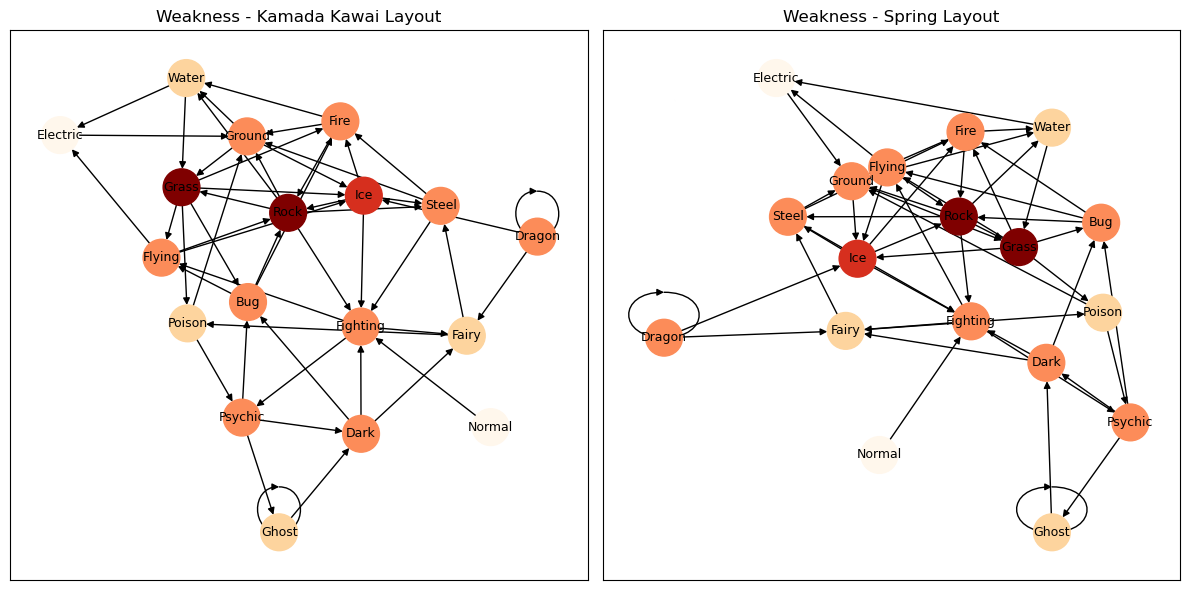

        Type  Out Degree
0       Rock           5
1      Grass           5
2        Ice           4
3   Fighting           3
4       Fire           3
5     Ground           3
6     Flying           3
7        Bug           3
8      Steel           3
9    Psychic           3
10      Dark           3
11    Dragon           3
12     Water           2
13    Poison           2
14     Fairy           2
15     Ghost           2
16    Normal           1
17  Electric           1


In [348]:
# Defending Type ------> Attacking Type
# Arrows indicate that the defending type has a weakness against the attacking type
# Reversal of the arrows in the Effective Attack graph

Weakness_Graph = nx.from_pandas_edgelist(pk_type_chart_effective, "Type 2", "Type 1", create_using=nx.DiGraph())
create_graph_visual(Weakness_Graph, "Weakness")

**Conclusion**: Grass and Rock have the most weaknesses (5), while Normal and Electric have the least (1). The graph also depicts that Dragon and Ghost each have a weakness against itself.

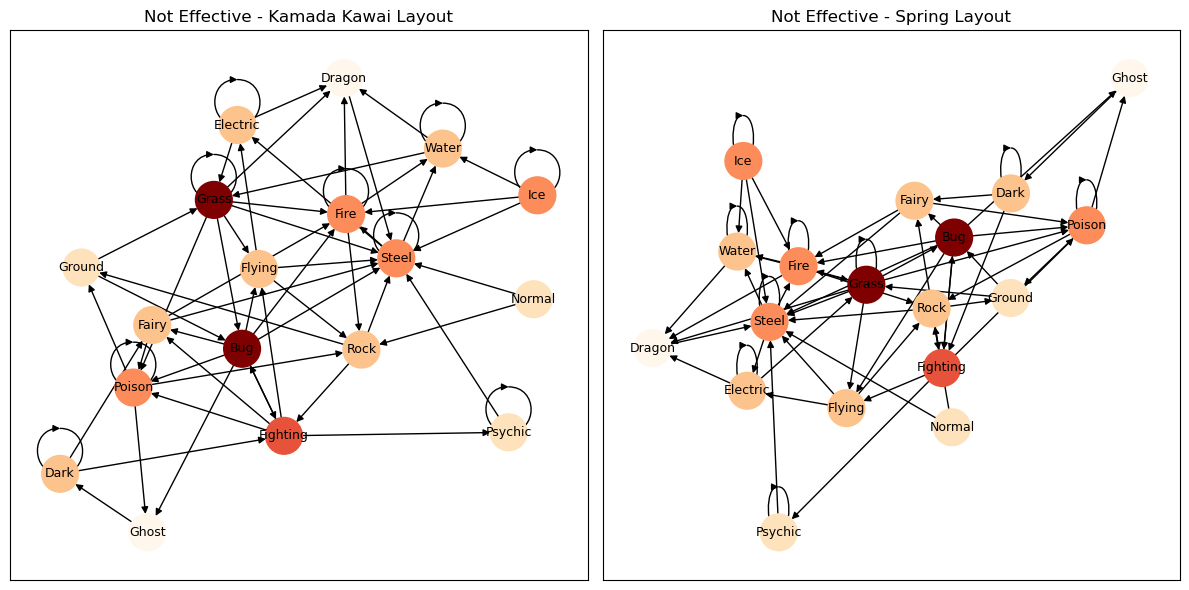

        Type  Out Degree
0      Grass           7
1        Bug           7
2   Fighting           5
3       Fire           4
4        Ice           4
5      Steel           4
6     Poison           4
7      Fairy           3
8      Water           3
9   Electric           3
10    Flying           3
11      Rock           3
12      Dark           3
13    Ground           2
14   Psychic           2
15    Normal           2
16     Ghost           1
17    Dragon           1


In [349]:
# Attacking Type ------> Defending Type
# Arrows indicate that the attacking type is not effective against the defending type (ex. Fighting is not very effective against Psychic)

Not_Effective_Graph = nx.from_pandas_edgelist(pk_type_chart_not_effective, "Type 1", "Type 2", create_using=nx.DiGraph())
create_graph_visual(Not_Effective_Graph, "Not Effective")

**Conclusion**: Grass and Bug are not very effective against the most number of types (7), while Ghost and Dragon are not very effective against the least number of types (1). There are multiple types that are not very effective against each other, such as Fire, Ice, and Psychic.

From the last two graphs, we can see that Grass has the most number of weaknesses and is not very effective against the most number of types. This highlights a major issue for Grass-type Pokemon in battle.

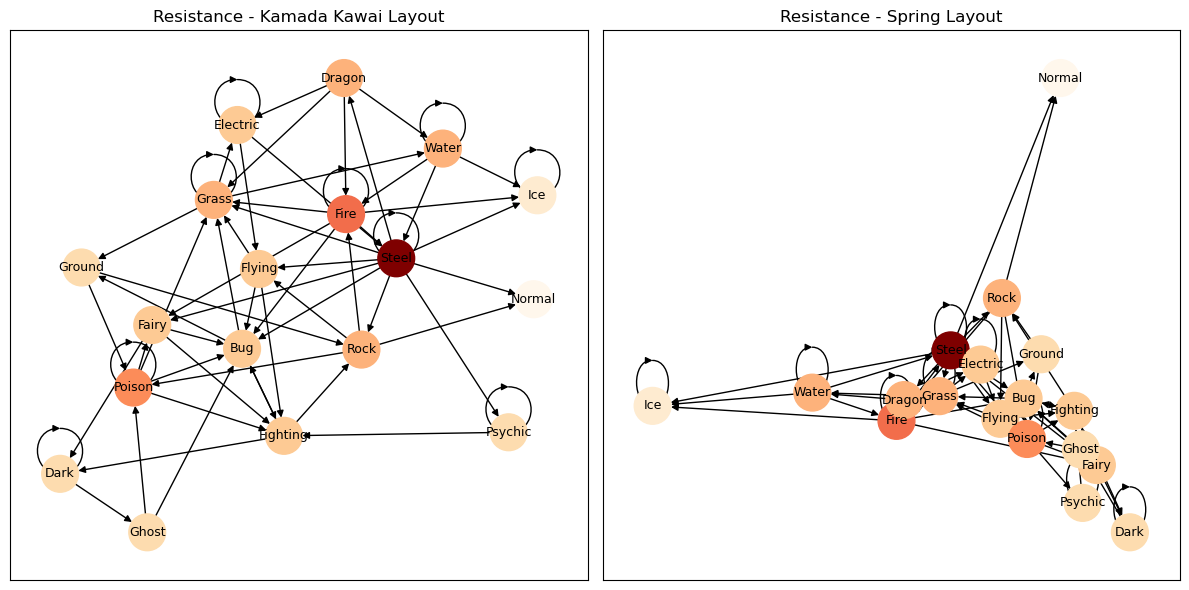

        Type  Out Degree
0      Steel          10
1       Fire           6
2     Poison           5
3      Grass           4
4      Water           4
5       Rock           4
6     Dragon           4
7        Bug           3
8      Fairy           3
9   Electric           3
10    Flying           3
11  Fighting           3
12    Ground           2
13      Dark           2
14   Psychic           2
15     Ghost           2
16       Ice           1
17    Normal           0


In [352]:
# Defending Type ------> Attacking Type
# Arrows indicate that the defending type has resistance against the attacking type
# Reversal of the arrows in the Not Effective Graph

Resistance_Graph = nx.from_pandas_edgelist(pk_type_chart_not_effective, "Type 2", "Type 1", create_using=nx.DiGraph())
create_graph_visual(Resistance_Graph, "Resistance")

**Conclusion**: Steel has by far the most number of resistances against other types (10), while Normal has the least (0). 

- We see something similar in the spring layout that we saw with the Effective Attack Graph, in that Ice and Normal are isolated from the rest of the types (which are clustered together). This is because Normal does not have any outward relationships, while Ice only has one outward relationship pointing toward itself.

In [515]:
# Defending Type ------> Attacking Type
# not used for visualization purposes because not every type has an immunity

Immunity_Graph = nx.from_pandas_edgelist(pk_type_chart_immunity, "Type 2", "Type 1", create_using=nx.DiGraph())

A challenge for many Pokemon players is being able to determine what types their Pokemon are weak and resistant to, especially when their Pokemon has a dual typing. These dual typings are more complicated because one type's weakness can be counteracted by another type's resistance, meaning that a move with that typing would have an overall neutral effect on the Pokemon. Take a Grass/Poison type as an example: while Grass types are usually weak to Bug types, Poison types are resistant to Bug-type moves. Therefore, the Bug type will have an overall neutral effect on the Grass/Poison typed Pokemon.

Weaknesses and resistances can also be made stronger due to dual typing, if both of the types resist or are weak to a certain typing. I wanted to create a graph visualization that would display each Pokemon as the center node with arrows pointing out to the types it is resistant, weak, or immune from.

In [519]:
# importing the data that contains Pokemon and their typings

pokemon_data = pd.read_csv("pokemon.csv")
pokemon_data = pokemon_data[["name", "type1", "type2"]]
pokemon_data

,name,type1,type2
0,Bulbasaur,grass,poison
1,Ivysaur,grass,poison
2,Venusaur,grass,poison
3,Charmander,fire,NaN
4,Charmeleon,fire,NaN
...,...,...,...
796,Celesteela,steel,flying
797,Kartana,grass,steel
798,Guzzlord,dark,dragon
799,Necrozma,psychic,NaN


In [520]:
# FUNCTION: takes in a Pokemon name and returns its weaknesses, resistances, and immunities
# these will eventually be used to create the personalized graph for each Pokemon that displays its relationships with other types

def type_categorize(pokemon_name):
    pok = pokemon_data[pokemon_data["name"] == pokemon_name]
    pok_types = [list(pok["type1"])[0], list(pok["type2"])[0]]
    if type(pok_types[1]) is not str: # if the Pokemon only has one typing
        pok_types.pop()
    
    weaknesses_list = []
    resistance_list = []
    immunity_list = []
    
    for t in pok_types:
        t = t.capitalize()
        weaknesses_list.extend(list(Weakness_Graph.successors(t))) # using the graphs created earlier to derive the weaknesses of that typing
        resistance_list.extend(list(Resistance_Graph.successors(t))) # same for resistances
        if Immunity_Graph.has_node(t):
            immunity_list.extend(list(Immunity_Graph.successors(t))) # same for immunities

    # dictionaries are used to account for the strength of a resistance/weakness
    # if a type appears twice in the resistance list, the Pokemon is double-resistant to that specific type
    weakness_dict = Counter(weaknesses_list)
    resistance_dict = Counter(resistance_list)
    immunity_dict = Counter(immunity_list)
    
    weakness_dict_keys = list(weakness_dict.keys())
    
    for t in weakness_dict_keys: # removing types entirely that were categorized as both a weakness and resistance (balancing out)
        if t in resistance_dict:
            del weakness_dict[t]
            del resistance_dict[t]
    
    for t in immunity_dict: # removing types from the weakness/resistance dictionaries if a Pokemon is immune to it
        if t in weakness_dict:
            del weakness_dict[t]
        if t in resistance_dict:
            del resistance_dict[t]
    
    return [weakness_dict, resistance_dict, immunity_dict, pok_types]

In [508]:
# FUNCTION: translates the weaknesses, resistances, and immunities of a Pokemon into a graph representation

def draw_type_relationship(pokemon_name):
    dict_list = type_categorize(pokemon_name)
    weaknesses = dict_list[0]
    resistances = dict_list[1]
    immunities = dict_list[2]
    pok_types = dict_list[3]
    
    color_map = {pokemon_name: 'lightblue'}
    graph_edge_list = []
    
    G = nx.DiGraph()
    
    for weak in weaknesses:
        # print(weaknesses[weak])
        graph_edge_list.append((pokemon_name, weak, weaknesses[weak] ** 2))
        color_map[weak] = '#fd7a5e'
    
    for resis in resistances:
        graph_edge_list.append((pokemon_name, resis, resistances[resis] ** 2))
        color_map[resis] = '#5efd91'
    
    for immun in immunities:
        graph_edge_list.append((pokemon_name, immun, immunities[immun] ** 2))
        color_map[immun] = '#bdbdbd'
    
    G.add_weighted_edges_from(graph_edge_list)
    node_colors = [color_map[node] for node in G.nodes]
    weights = nx.get_edge_attributes(G, "weight")
    edge_widths = [weight for (u, v, weight) in G.edges(data="weight")]
    
    nx.draw(G, with_labels=True, node_color=node_colors, node_size = 1500, width=edge_widths)
    if len(pok_types) == 2:
        plt.title(f"{pokemon_name} - {pok_types[0].capitalize()}/{pok_types[1].capitalize()}")
    else:
        plt.title(f"{pokemon_name} - {pok_types[0].capitalize()}")
    plt.show()

In the graphs below:

- Green nodes are resistances
- Red nodes are weaknesses
- Grey nodes are immunities
- Thicker arrows correlate to the "strength" of the relationship (a thick arrow pointing to a green node shows a "double resistance")

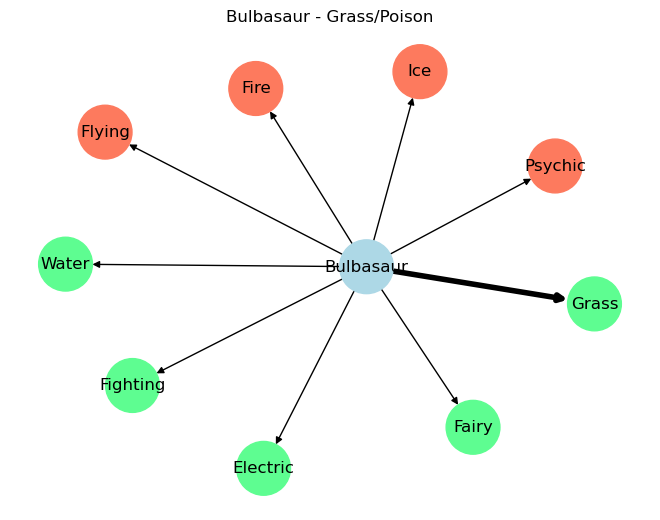

In [522]:
draw_type_relationship("Bulbasaur")

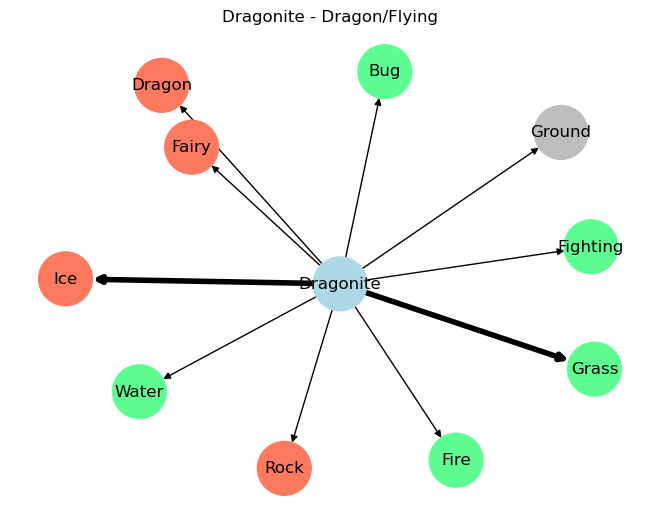

In [526]:
draw_type_relationship("Dragonite")

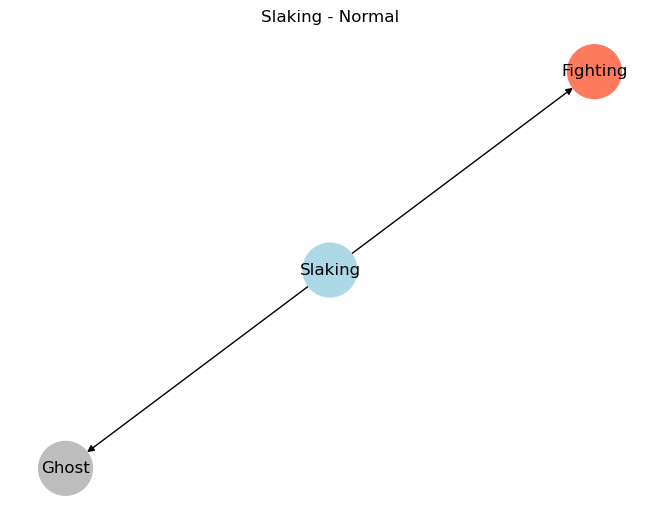

In [527]:
draw_type_relationship("Slaking")